### Library Imports

In [21]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import scipy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_squared_error
from sklearn.svm import SVC

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\seren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
lemmatizer = WordNetLemmatizer()

max_features = 9000
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=max_features)),
    ('tfidf_izer', TfidfTransformer())
])

In [4]:
mbti_types = ["istj", "isfj", "infj", "intj", "istp", "isfp", "infp", "intp",
             "estj", "esfj", "enfj", "entj", "estp", "esfp", "enfp", "entp"]

### Reading Target Data File

In [5]:
mbti_df = pd.read_csv(r"C:\Users\seren\OneDrive\Documents\datasets_3730\MBTI500.csv")

In [6]:
mbti_df.head()

posts  type
0  know intj tool use interaction people excuse a...  INTJ
1  rap music ehh opp yeah know valid well know fa...  INTJ
2  preferably p hd low except wew lad video p min...  INTJ
3  drink like wish could drink red wine give head...  INTJ
4  space program ah bad deal meing freelance max ...  INTJ

In [7]:
mbti_df = mbti_df[['type', 'posts']]
mbti_df.head()

type                                              posts
0  INTJ  know intj tool use interaction people excuse a...
1  INTJ  rap music ehh opp yeah know valid well know fa...
2  INTJ  preferably p hd low except wew lad video p min...
3  INTJ  drink like wish could drink red wine give head...
4  INTJ  space program ah bad deal meing freelance max ...

### Data Pre-Processing

In [8]:
column = 'posts'

exclude_types = ['XSTJ', 'XSFJ', 'XNFJ', 'XNTJ', 'XSTP', 'XSFP', 'XNFP', 'XNTP',
                 'IXTJ', 'IXFJ', 'IXTP', 'IXFP', 'EXTJ', 'EXFJ', 'EXTP', 'EXFP',
                 'ISXJ', 'INXJ', 'ISXP', 'INXP', 'ESXP', 'ENXP', 'ESXJ', 'ENXJ',
                 'ISTX', 'ISFX', 'INFX', 'INTX', 'ESTX', 'ESFX', 'ENFX', 'ENTX']


# to lower case
mbti_df[column] = mbti_df[column].str.lower()

# remove URLs
mbti_df[column] = mbti_df[column].apply(lambda x: re.sub(r'http\S+', ' ', str(x), flags = re.MULTILINE))

# remove special characters and numbers
mbti_df[column] = mbti_df[column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', str(x)))

# remove extra spaces
mbti_df[column] = mbti_df[column].str.replace(r'\s+', ' ', regex = True)

# remove repeating letter words
mbti_df[column] = mbti_df[column].apply(lambda x: ' '.join([word for word in str(x).split() if not re.search(r'(.)\1\1\1\1', word)]))

# remove x-mbti
for mbti in exclude_types:
    mbti_df[column] = mbti_df[column].str.replace(mbti.lower(), '')

# remove the stop words
stopWords = set(stopwords.words('english'))
mbti_df[column] = mbti_df[column].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopWords]))

# remove the mbti types from the dataset
for mbti in mbti_types:
    mbti_df[column] = mbti_df[column].str.replace(mbti.lower(), '')

# lemmatize the words in the dataset
mbti_df[column] = mbti_df[column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in str(x).split()]))

In [9]:
mbti_df.head(3)

type                                              posts
0  INTJ  know tool use interaction people excuse antiso...
1  INTJ  rap music ehh opp yeah know valid well know fa...
2  INTJ  preferably p hd low except wew lad video p min...

In [10]:
per_MBTI = {}

for mbti in mbti_df['type'].unique():
    per_MBTI[mbti] = mbti_df[mbti_df['type']==mbti].copy()

for mbti, data in per_MBTI.items():
    data.to_csv(f'C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_{mbti}.csv', index=False, mode='w')

In [11]:
per_letters = {}

letterList = {'I', 'E', 'S', 'N', 'T', 'F', 'J', 'P'}

for letters in letterList:
    letter_subset = mbti_df['type'].str.contains(letters).copy()

    letter_subset.to_csv(f'C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_{letters}.csv', index=False, mode='w')
    per_letters[letters] = letter_subset

### Dimensions and Personality Types

In [12]:
I = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_I.csv')
E = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_E.csv')

N = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_N.csv')
S = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_S.csv')

F = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_F.csv')
T = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_T.csv')

J = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_J.csv')
P = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_letters/big_P.csv')

In [13]:
mbti_df.shape

(106067, 2)

In [14]:
ENFJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ENFJ.csv')
ENFP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ENFP.csv')
ENTJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ENTJ.csv')
ENTP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ENTP.csv')
ESFJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ESFJ.csv')
ESFP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ESFP.csv')
ESTJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ESTJ.csv')
ESTP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ESTP.csv')
INFJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_INFJ.csv')
INFP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_INFP.csv')
INTJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_INTJ.csv')
INTP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_INTP.csv')
ISFJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ISFJ.csv')
ISFP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ISFP.csv')
ISTJ = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ISTJ.csv')
ISTP = pd.read_csv('C:/Users/seren/OneDrive/Documents/datasets_3730/big_datasets_types/big_ISTP.csv')

In [15]:
IvE = pd.DataFrame()
IvE['type'] = I['type'].apply(lambda x: 'I' if x else 'E')

NvS = pd.DataFrame()
NvS['type'] = N['type'].apply(lambda x: 'N' if x else 'S')

FvT = pd.DataFrame()
FvT['type'] = F['type'].apply(lambda x: 'F' if x else 'T')

PvJ = pd.DataFrame()
PvJ['type'] = P['type'].apply(lambda x: 'P' if x else 'J')

In [16]:
new_mbti_df = pd.concat([IvE.rename(columns={'type': 'IvE'}), 
                         NvS.rename(columns={'type': 'NvS'}), 
                         FvT.rename(columns={'type': 'FvT'}), 
                         PvJ.rename(columns={'type': 'PvJ'}), 
                         mbti_df], axis=1)
new_mbti_df.head()

IvE NvS FvT PvJ  type                                              posts
0   I   N   T   J  INTJ  know tool use interaction people excuse antiso...
1   I   N   T   J  INTJ  rap music ehh opp yeah know valid well know fa...
2   I   N   T   J  INTJ  preferably p hd low except wew lad video p min...
3   I   N   T   J  INTJ  drink like wish could drink red wine give head...
4   I   N   T   J  INTJ  space program ah bad deal meing freelance max ...

### Feature Extraction

In [17]:
features = pipeline.fit_transform(new_mbti_df['posts'])
features_df = pd.DataFrame(features.toarray(), columns=pipeline.named_steps['vectorizer'].get_feature_names_out())
features_df.head()

aa   ab  abandon  abandonment  abhor  abide  ability      able  abnormal  \
0  0.0  0.0      0.0          0.0    0.0    0.0      0.0  0.000000       0.0   
1  0.0  0.0      0.0          0.0    0.0    0.0      0.0  0.052072       0.0   
2  0.0  0.0      0.0          0.0    0.0    0.0      0.0  0.000000       0.0   
3  0.0  0.0      0.0          0.0    0.0    0.0      0.0  0.000000       0.0   
4  0.0  0.0      0.0          0.0    0.0    0.0      0.0  0.000000       0.0   

   abolish  ...  zealand  zelda  zen  zero  zip  zodiac  zombie      zone  \
0      0.0  ...      0.0    0.0  0.0   0.0  0.0     0.0     0.0  0.000000   
1      0.0  ...      0.0    0.0  0.0   0.0  0.0     0.0     0.0  0.000000   
2      0.0  ...      0.0    0.0  0.0   0.0  0.0     0.0     0.0  0.039644   
3      0.0  ...      0.0    0.0  0.0   0.0  0.0     0.0     0.0  0.000000   
4      0.0  ...      0.0    0.0  0.0   0.0  0.0     0.0     0.0  0.000000   

   zoo  zoom  
0  0.0   0.0  
1  0.0   0.0  
2  0.0   0.0  
3  0.0   0.0  
4  0.0   0.0  

[5 rows x 9000 columns]

### Plotting Word Cloud and Importance for each MBTI Types

#### Word Cloud

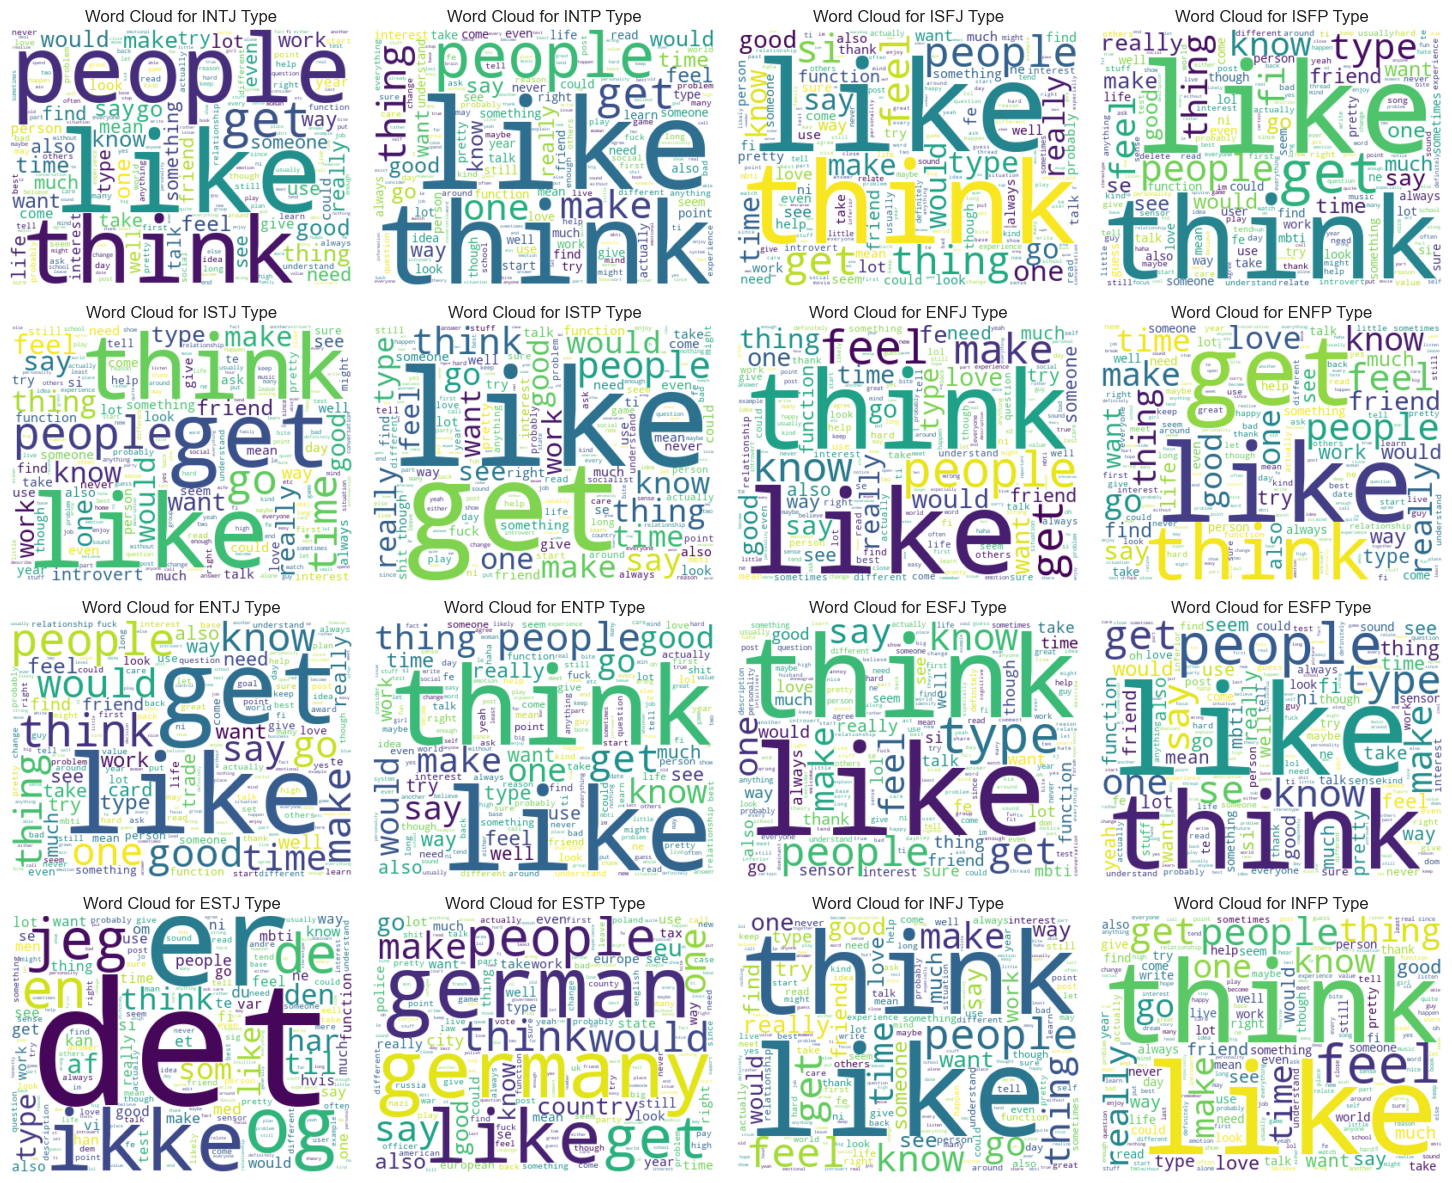

In [138]:
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

# Iterate over personality types and generate word clouds
for idx, personality_type in enumerate(mbti_types):
    ax = axes[idx // 4, idx % 4]
    
    # Filter features for the specific personality type
    type_features = features_df[new_mbti_df['type'] == personality_type]
    
    # Calculate mean TF-IDF values for each word
    mean_tfidf_values = type_features.sum(axis=0)
    
    # Sort words based on mean TF-IDF values in descending order
    sorted_words = mean_tfidf_values.sort_values(ascending=False)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(sorted_words)
    
    # Display the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {personality_type} Type')
    ax.axis('off')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


#### WordCloud Removed

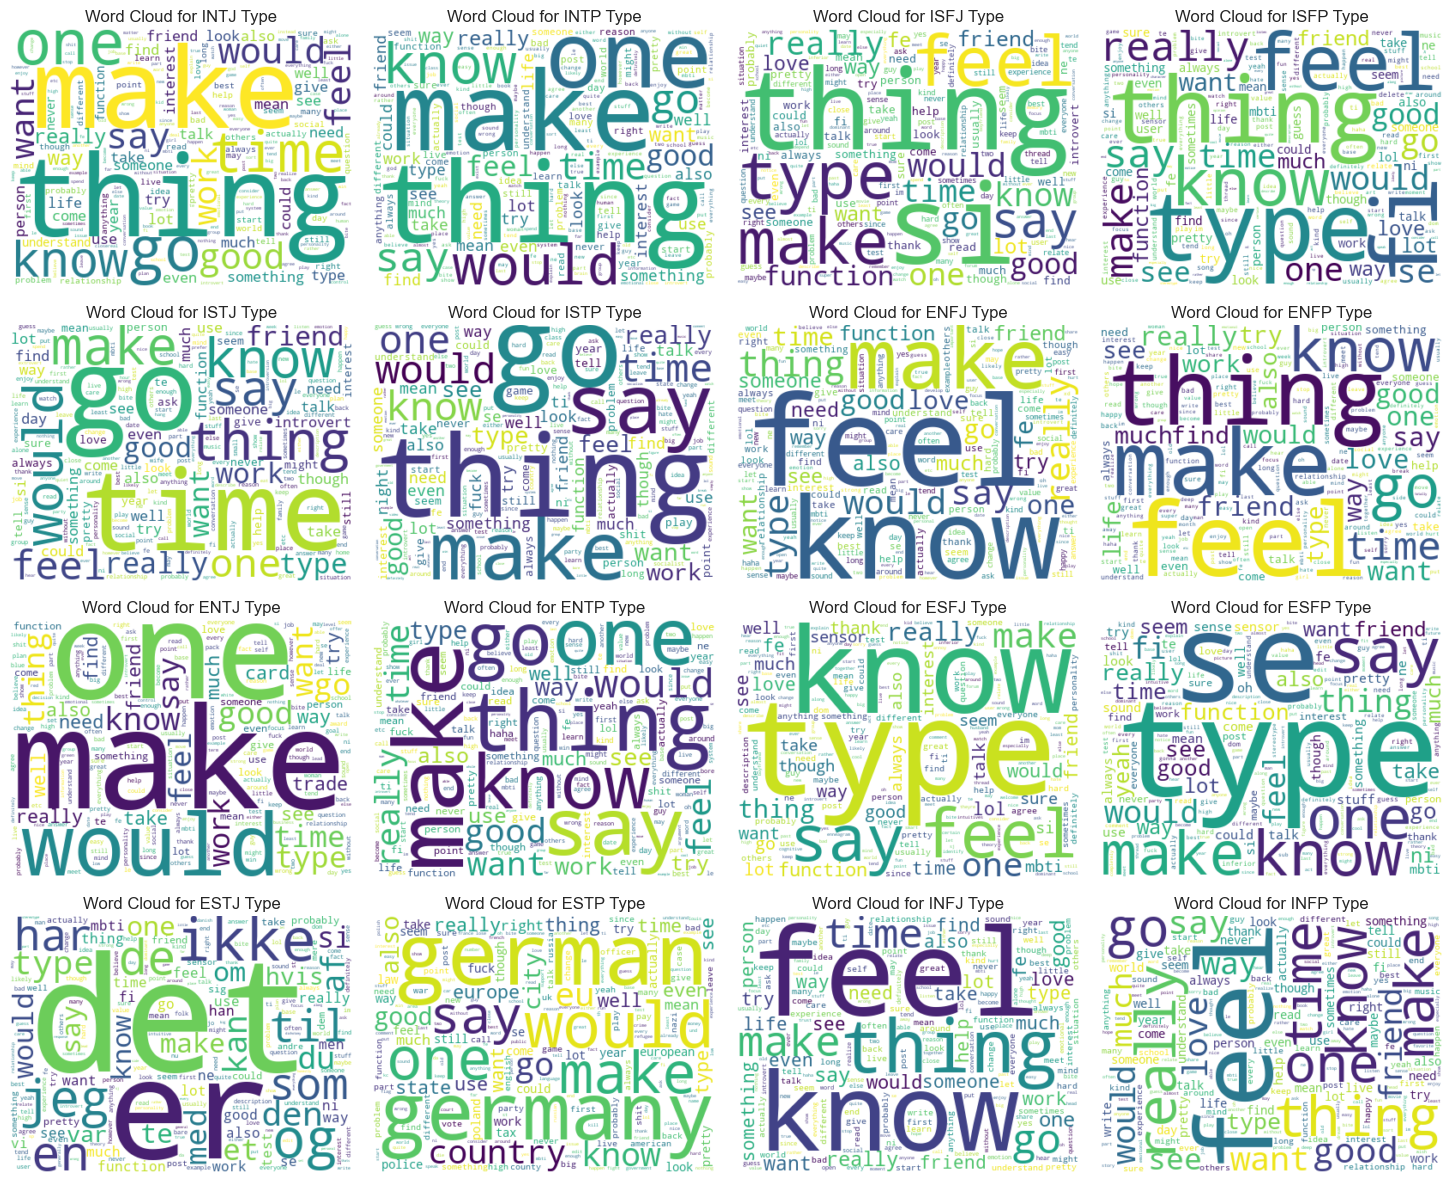

In [144]:
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

# Words to remove
words_to_remove = ['think', 'like', 'get', 'people']

# Iterate over personality types and generate word clouds
for idx, personality_type in enumerate(mbti_types):
    ax = axes[idx // 4, idx % 4]
    
    # Filter features for the specific personality type
    type_features = features_df[new_mbti_df['type'] == personality_type]
    
    # Calculate mean TF-IDF values for each word
    mean_tfidf_values = type_features.sum(axis=0)
    
    # Sort words based on mean TF-IDF values in descending order
    sorted_words = mean_tfidf_values.sort_values(ascending=False)
    
    # Remove specified words
    sorted_words = sorted_words.drop(words_to_remove, errors='ignore')
    
    # Generate a word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(sorted_words)
    
    # Display the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {personality_type} Type')
    ax.axis('off')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

#### Bar Graph

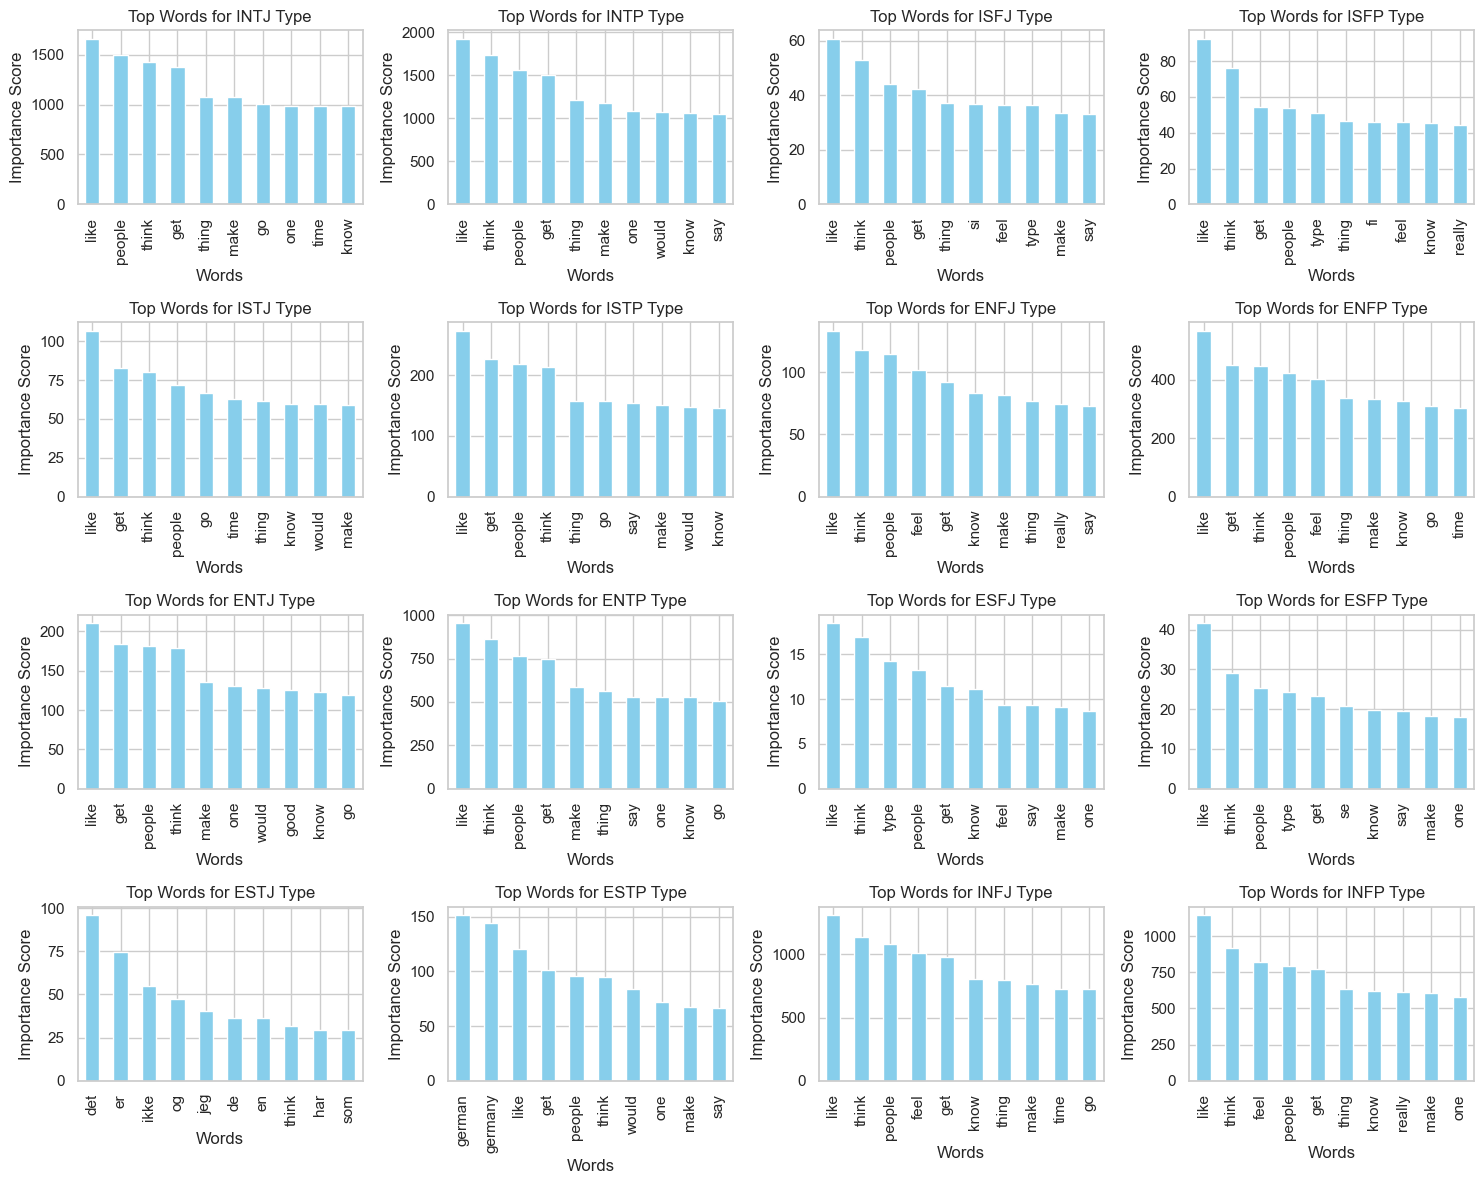

In [141]:
# Set the number of top words to display
top_n = 10

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

# Iterate over personality types and plot bar graphs
for idx, personality_type in enumerate(mbti_types):
    ax = axes[idx // 4, idx % 4]
    
    # Filter features for the specific personality type
    type_features = features_df[new_mbti_df['type'] == personality_type]
    
    # Calculate mean TF-IDF values for each word
    mean_tfidf_values = type_features.sum(axis=0)
    
    # Sort words based on mean TF-IDF values in descending order
    sorted_words = mean_tfidf_values.sort_values(ascending=False)
    
    # Plot the top N words
    sorted_words.head(top_n).plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Top Words for {personality_type} Type')
    ax.set_xlabel('Words')
    ax.set_ylabel('Importance Score')   
plt.tight_layout()    
plt.show()

#### Pie Chart

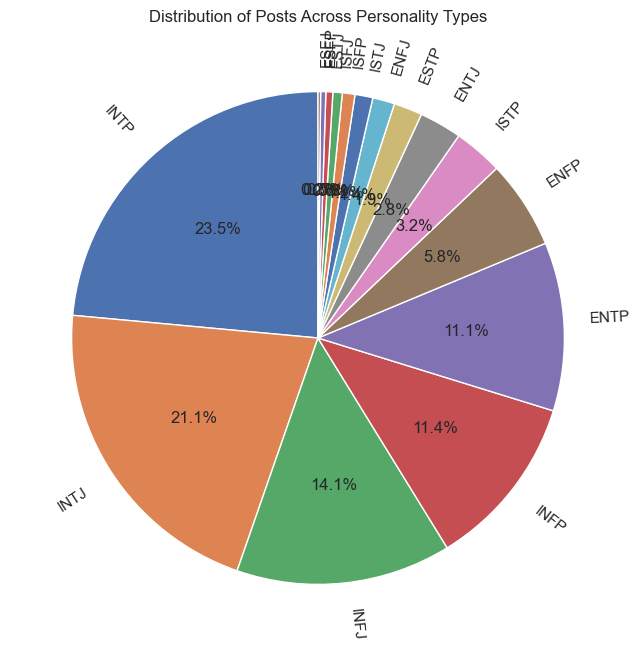

In [148]:
post_counts = new_mbti_df['type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(post_counts, labels=post_counts.index, autopct='%1.1f%%', startangle=90, rotatelabels=90)
plt.title('Distribution of Posts Across Personality Types')
plt.show()

### Classification v. Frequency Plots

In [133]:
I_count = I['type'].sum()
E_count = E['type'].sum()

N_count = N['type'].sum()
S_count = S['type'].sum()

F_count = F['type'].sum()
T_count = T['type'].sum()

J_count = J['type'].sum()
P_count = P['type'].sum()

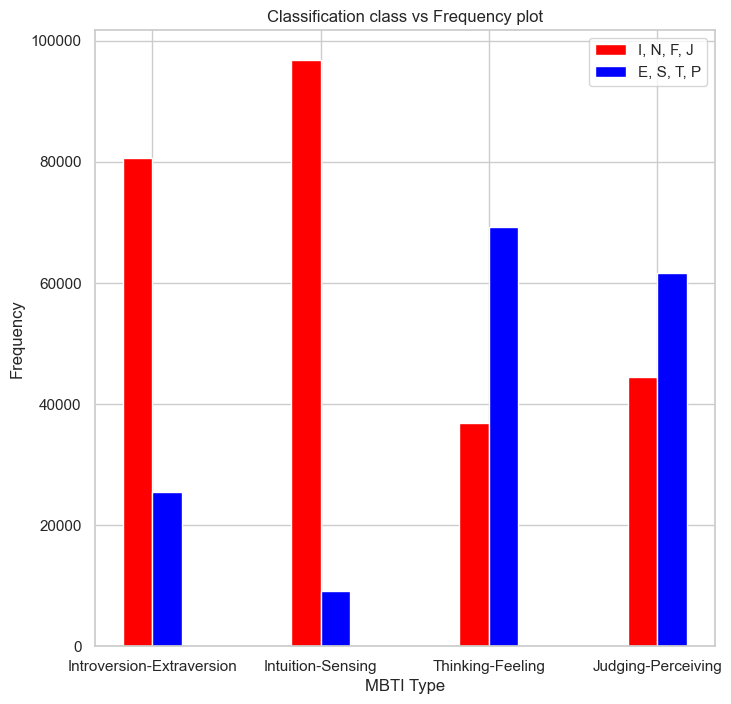

In [134]:
plt.figure(figsize=(8, 8))

categories = ['Introversion-Extraversion', 'Intuition-Sensing', 'Thinking-Feeling', 'Judging-Perceiving']
coordinates = np.arange(len(categories)) * 2
width = 0.35  # Width of the bars

# Bar plot for I, N, F, J
plt.bar(coordinates - width/2, [I_count, N_count, F_count, J_count], width, label="I, N, F, J", color='red')

# Bar plot for E, S, T, P
plt.bar(coordinates + width/2, [E_count, S_count, T_count, P_count], width, label="E, S, T, P", color='blue')

plt.legend()
plt.title('Classification class vs Frequency plot')
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.xticks(coordinates, categories)

plt.show()


### Training and Testing

In [18]:
# Convert your DataFrame to a sparse matrix
sparse_features = csr_matrix(features_df)

# Now, you can use sparse_features for training and testing


In [19]:
start_index = 37670
end_index = 69492

# Training data
x_train_ie = sparse_features[np.r_[:start_index, end_index:]]
y_train_ie = new_mbti_df['IvE'][np.r_[:start_index, end_index:]]

# Testing data
x_test_ie = sparse_features[start_index:end_index]
y_test_ie = new_mbti_df['IvE'][start_index:end_index]

In [20]:
x_train_ns, x_test_ns, y_train_ns, y_test_ns = train_test_split(sparse_features, new_mbti_df['NvS'], test_size=0.3, random_state=123)
x_train_pj, x_test_pj, y_train_pj, y_test_pj = train_test_split(sparse_features, new_mbti_df['PvJ'], test_size=0.3, random_state=123)
x_train_ft, x_test_ft, y_train_ft, y_test_ft = train_test_split(sparse_features, new_mbti_df['FvT'], test_size=0.3, random_state=123)

In [108]:
# start_index = 37670
# end_index = 69492

# # Training data
# x_train_ft = sparse_features[np.r_[:start_index, end_index:]]
# y_train_ft = new_mbti_df['FvT'][np.r_[:start_index, end_index:]]

# # Testing data
# x_test_ft = sparse_features[start_index:end_index]
# y_test_ft = new_mbti_df['FvT'][start_index:end_index]

### Applying Machine Learning Algorithms

#### Naive Bayes Model

In [74]:
naive_bayes = MultinomialNB()

In [75]:
nb_grid_search_ie = GridSearchCV(naive_bayes, {}, cv=5)

y_nb_ie = nb_grid_search_ie.fit(x_train_ie, y_train_ie).best_estimator_.predict(x_test_ie)
print(f'\nPrediction: {y_nb_ie}')

print(classification_report(y_test_ie, y_pred=y_nb_ie))

acc_nb_ie = accuracy_score(y_test_ie, y_pred=y_nb_ie)
print(f'\nAccuracy Score: {acc_nb_ie}')


Prediction: ['I' 'I' 'I' ... 'I' 'I' 'I']
              precision    recall  f1-score   support

           E       0.96      0.03      0.07     15912
           I       0.51      1.00      0.67     15910

    accuracy                           0.52     31822
   macro avg       0.73      0.52      0.37     31822
weighted avg       0.73      0.52      0.37     31822


Accuracy Score: 0.5165608698384765


<Figure size 640x480 with 0 Axes>

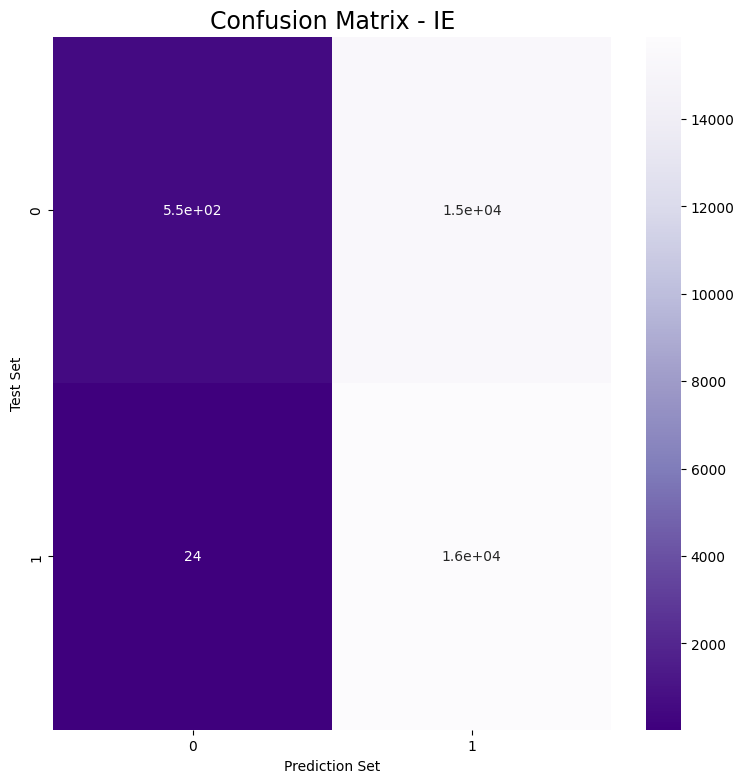

In [76]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_ie, y_nb_ie)
sns.heatmap(confusion_Matrix, annot=True, cmap='Purples_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - IE', size=17)
plt.show()

In [77]:
nb_grid_search_ns = GridSearchCV(naive_bayes, {}, cv=5)

y_nb_ns = nb_grid_search_ns.fit(x_train_ns, y_train_ns).best_estimator_.predict(x_test_ns)
print(f'\nPrediction: {y_nb_ns}')

print(classification_report(y_test_ns, y_pred=y_nb_ns))

acc_nb_ns = accuracy_score(y_test_ns, y_pred=y_nb_ns)
print(f'\nAccuracy Score: {acc_nb_ns}')


Prediction: ['N' 'N' 'N' ... 'N' 'N' 'N']
              precision    recall  f1-score   support

           N       0.81      1.00      0.89     25630
           S       0.96      0.01      0.03      6192

    accuracy                           0.81     31822
   macro avg       0.89      0.51      0.46     31822
weighted avg       0.84      0.81      0.72     31822


Accuracy Score: 0.8079001948337629


<Figure size 640x480 with 0 Axes>

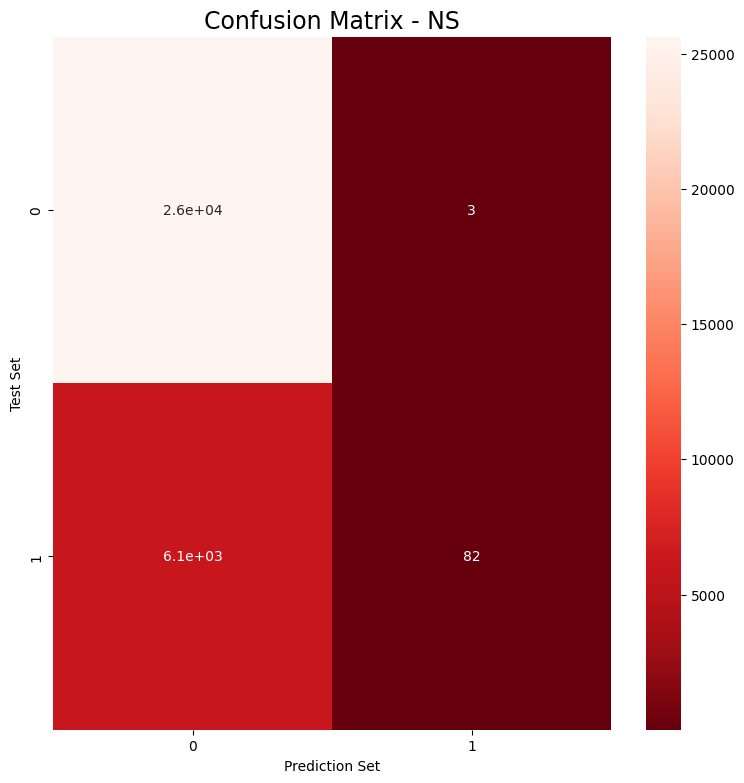

In [78]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_ns, y_nb_ns)
sns.heatmap(confusion_Matrix, annot=True, cmap='Reds_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - NS', size=17)
plt.show()

In [79]:
nb_grid_search_ft = GridSearchCV(naive_bayes, {}, cv=5)

y_nb_ft = nb_grid_search_ft.fit(x_train_ft, y_train_ft).best_estimator_.predict(x_test_ft)
print(f'\nPrediction: {y_nb_ft}')

print(classification_report(y_test_ft, y_pred=y_nb_ft))

acc_nb_ft = accuracy_score(y_test_ft, y_pred=y_nb_ft)
print(f'\nAccuracy Score: {acc_nb_ft}')


Prediction: ['T' 'T' 'T' ... 'T' 'T' 'T']
              precision    recall  f1-score   support

           F       0.95      0.03      0.06      9226
           T       0.72      1.00      0.83     22596

    accuracy                           0.72     31822
   macro avg       0.83      0.52      0.45     31822
weighted avg       0.78      0.72      0.61     31822


Accuracy Score: 0.7190622839544969


<Figure size 640x480 with 0 Axes>

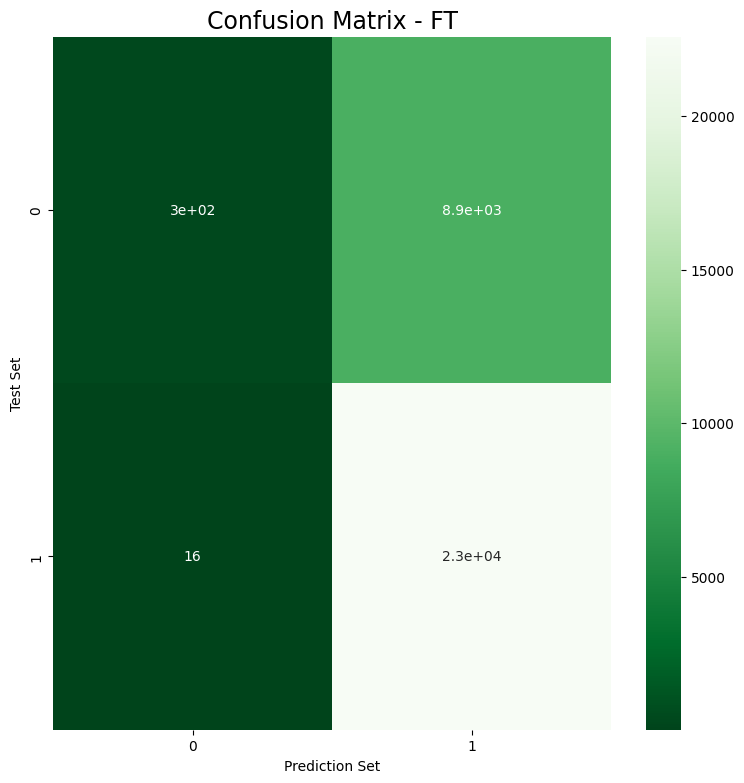

In [80]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_ft, y_nb_ft)
sns.heatmap(confusion_Matrix, annot=True, cmap='Greens_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - FT', size=17)
plt.show()

In [81]:
nb_grid_search_pj = GridSearchCV(naive_bayes, {}, cv=5)

y_nb_pj = nb_grid_search_pj.fit(x_train_pj, y_train_pj).best_estimator_.predict(x_test_pj)
print(f'\nPrediction: {y_nb_pj}')

print(classification_report(y_test_pj, y_pred=y_nb_pj))

acc_nb_pj = accuracy_score(y_test_pj, y_pred=y_nb_pj)
print(f'\nAccuracy Score: {acc_nb_pj}')


Prediction: ['P' 'J' 'P' ... 'P' 'P' 'P']
              precision    recall  f1-score   support

           J       0.52      0.61      0.56      6382
           P       0.90      0.86      0.88     25440

    accuracy                           0.81     31822
   macro avg       0.71      0.73      0.72     31822
weighted avg       0.82      0.81      0.81     31822


Accuracy Score: 0.8065489284143046


<Figure size 640x480 with 0 Axes>

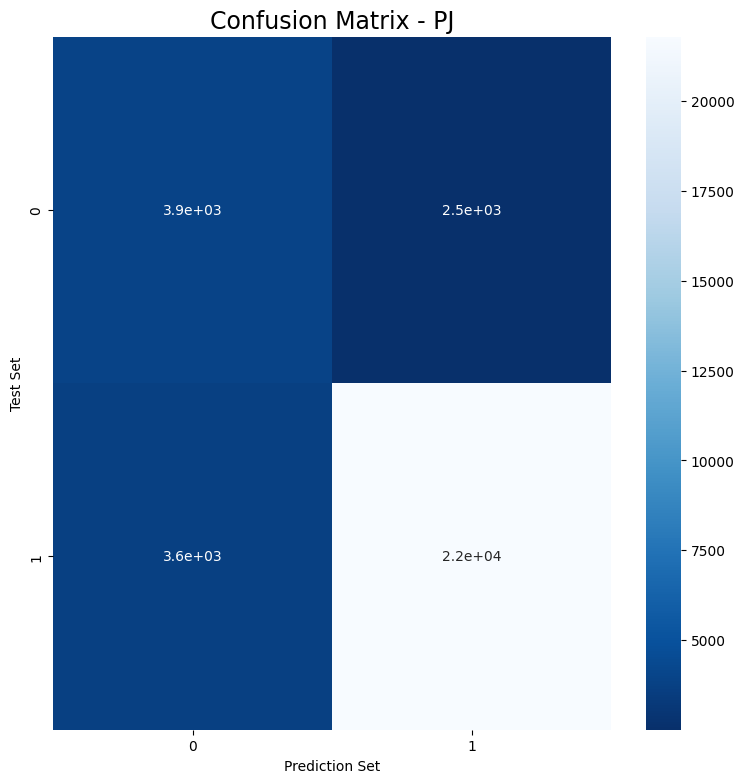

In [82]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_pj, y_nb_pj)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - PJ', size=17)
plt.show()

#### Logistic Regression

In [109]:
lr_model = LogisticRegression(max_iter=500)

In [110]:
lr_grid_search_ie = GridSearchCV(lr_model, {}, cv=5)

y_lr_ie = lr_grid_search_ie.fit(x_train_ie, y_train_ie).best_estimator_.predict(x_test_ie)
print(f'\nPrediction: {y_lr_ie}')

print(classification_report(y_test_ie, y_pred=y_lr_ie))

acc_lr_ie = accuracy_score(y_test_ie, y_pred=y_lr_ie)
print(f'\nAccuracy Score: {acc_lr_ie}')


Prediction: ['I' 'I' 'I' ... 'E' 'E' 'I']
              precision    recall  f1-score   support

           E       0.94      0.57      0.71     15912
           I       0.69      0.96      0.80     15910

    accuracy                           0.77     31822
   macro avg       0.81      0.77      0.76     31822
weighted avg       0.81      0.77      0.76     31822


Accuracy Score: 0.7666708566400603


<Figure size 640x480 with 0 Axes>

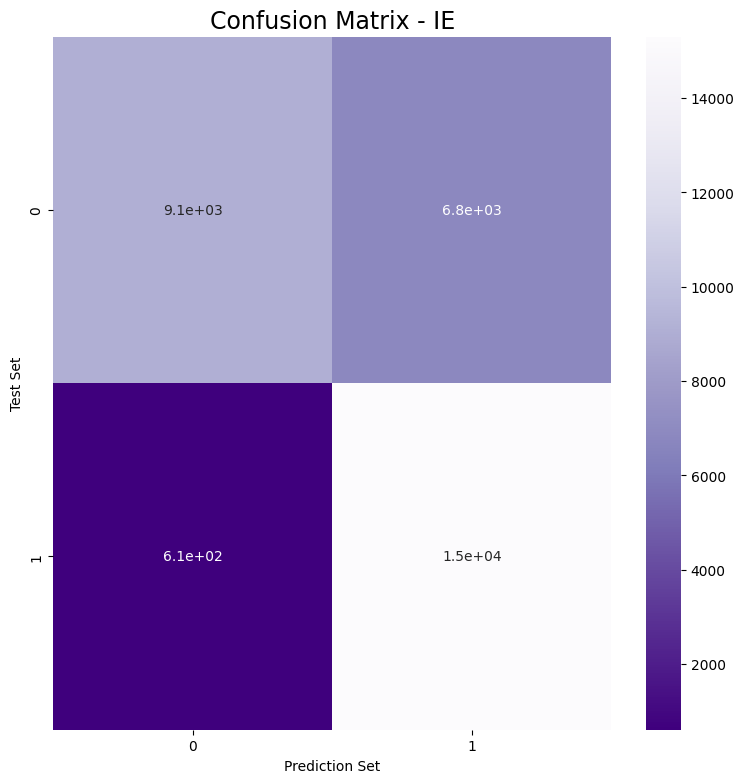

In [111]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_ie, y_lr_ie)
sns.heatmap(confusion_Matrix, annot=True, cmap='Purples_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - IE', size=17)
plt.show()

In [112]:
lr_grid_search_ns = GridSearchCV(lr_model, {}, cv=5)

y_lr_ns = lr_grid_search_ns.fit(x_train_ns, y_train_ns).best_estimator_.predict(x_test_ns)
print(f'\nPrediction: {y_lr_ns}')

print(classification_report(y_test_ns, y_pred=y_lr_ns))

acc_lr_ns = accuracy_score(y_test_ns, y_pred=y_lr_ns)
print(f'\nAccuracy Score: {acc_lr_ns}')


Prediction: ['N' 'N' 'N' ... 'N' 'S' 'N']
              precision    recall  f1-score   support

           N       0.95      1.00      0.97     29091
           S       0.89      0.39      0.54      2730

    accuracy                           0.94     31821
   macro avg       0.92      0.69      0.75     31821
weighted avg       0.94      0.94      0.93     31821


Accuracy Score: 0.9432136010810471


<Figure size 640x480 with 0 Axes>

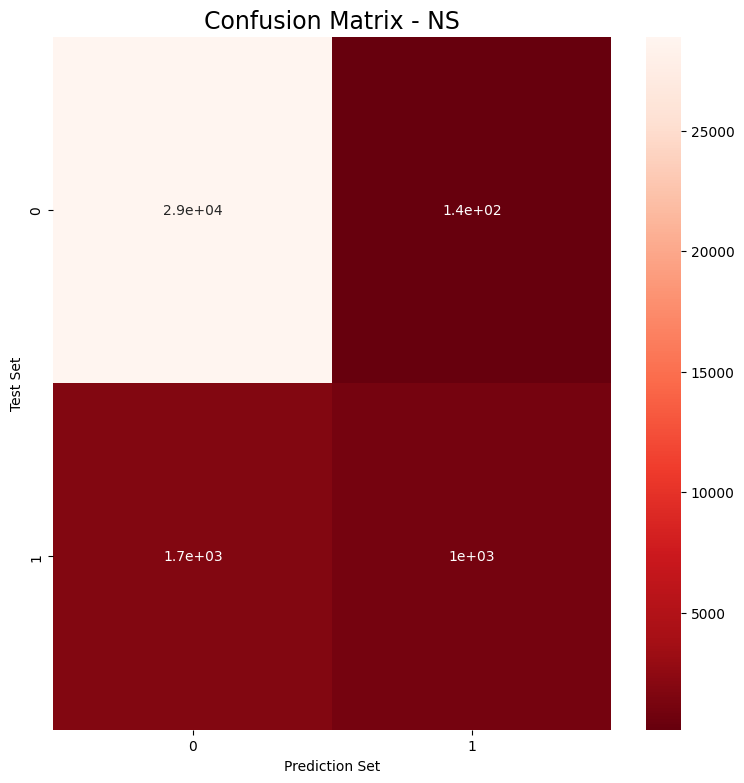

In [44]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_ns, y_lr_ns)
sns.heatmap(confusion_Matrix, annot=True, cmap='Reds_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - NS', size=17)
plt.show()

In [113]:
lr_grid_search_ft = GridSearchCV(lr_model, {}, cv=5)

y_lr_ft = lr_grid_search_ft.fit(x_train_ft, y_train_ft).best_estimator_.predict(x_test_ft)
print(f'\nPrediction: {y_lr_ft}')

print(classification_report(y_test_ft, y_pred=y_lr_ft))

acc_lr_ft = accuracy_score(y_test_ft, y_pred=y_lr_ft)
print(f'\nAccuracy Score: {acc_lr_ft}')


Prediction: ['T' 'T' 'T' ... 'T' 'T' 'T']
              precision    recall  f1-score   support

           F       0.95      0.62      0.75      9226
           T       0.86      0.99      0.92     22596

    accuracy                           0.88     31822
   macro avg       0.91      0.80      0.84     31822
weighted avg       0.89      0.88      0.87     31822


Accuracy Score: 0.8807743070831501


<Figure size 640x480 with 0 Axes>

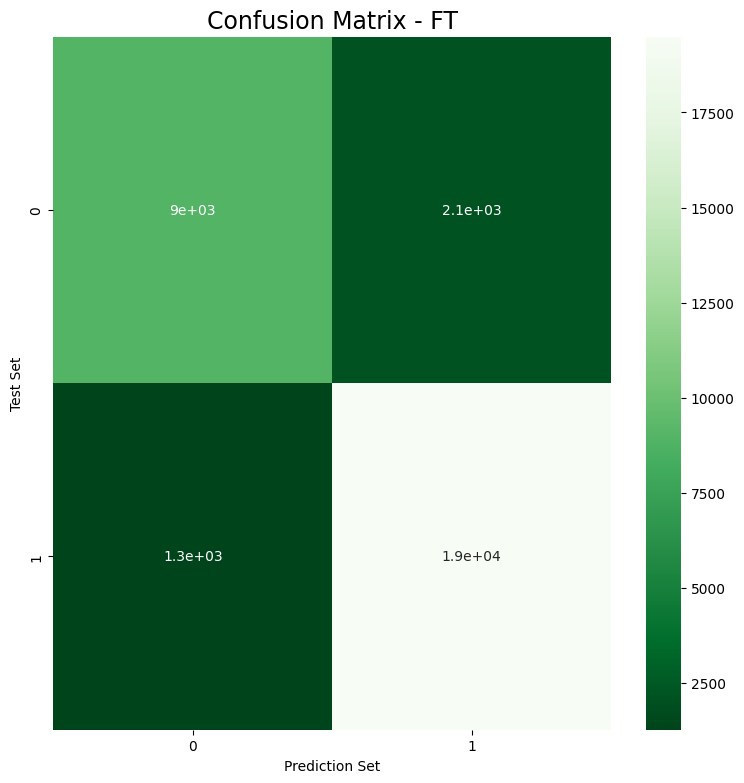

In [46]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_ft, y_lr_ft)
sns.heatmap(confusion_Matrix, annot=True, cmap='Greens_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - FT', size=17)
plt.show()

In [114]:
lr_grid_search_pj = GridSearchCV(lr_model, {}, cv=5)

y_lr_pj = lr_grid_search_pj.fit(x_train_pj, y_train_pj).best_estimator_.predict(x_test_pj)
print(f'\nPrediction: {y_lr_pj}')

print(classification_report(y_test_pj, y_pred=y_lr_pj))

acc_lr_pj = accuracy_score(y_test_pj, y_pred=y_lr_pj)
print(f'\nAccuracy Score: {acc_lr_pj}')


Prediction: ['J' 'P' 'P' ... 'J' 'P' 'P']
              precision    recall  f1-score   support

           J       0.76      0.69      0.72     13311
           P       0.79      0.84      0.82     18510

    accuracy                           0.78     31821
   macro avg       0.78      0.77      0.77     31821
weighted avg       0.78      0.78      0.78     31821


Accuracy Score: 0.7787938782564973


<Figure size 640x480 with 0 Axes>

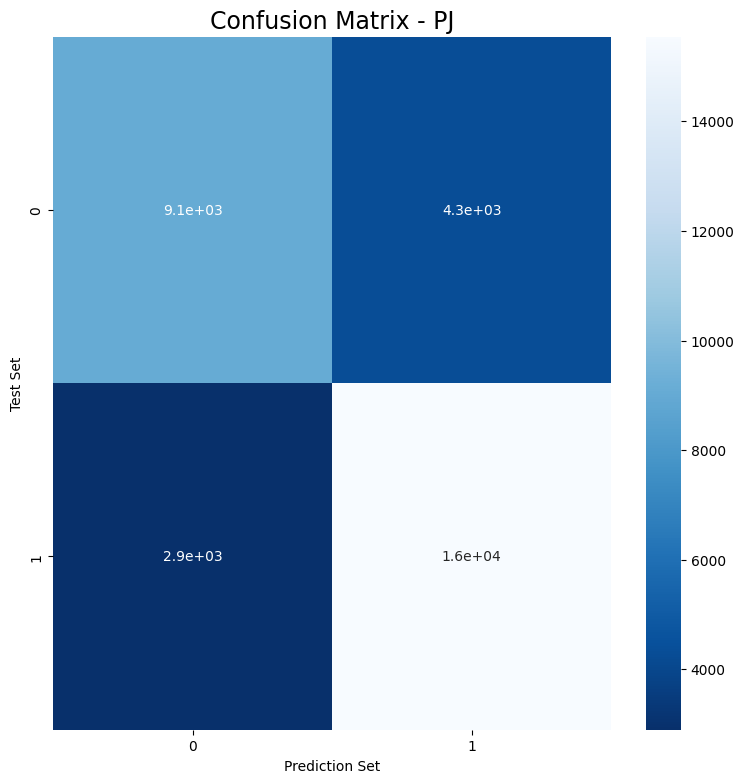

In [48]:
plt.figure()
plt.figure(figsize=(9,9))
confusion_Matrix = metrics.confusion_matrix(y_test_pj, y_lr_pj)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues_r')
plt.ylabel('Test Set')
plt.xlabel('Prediction Set')
plt.title('Confusion Matrix - PJ', size=17)
plt.show()

#### Support Vector Classifier

In [22]:
svm_ie = SVC(random_state=123, probability=True)
svm_ie.fit(x_train_ie, y_train_ie)

svc_ypred_ie = svm_ie.predict(x_test_ie) 
print(f'\nPrediction: {svc_ypred_ie}')

print(classification_report(y_test_ie, y_pred=svc_ypred_ie))

acc_svc_ie = accuracy_score(y_test_ie, y_pred=svc_ypred_ie)
print(f'\nAccuracy Score: {acc_svc_ie}')

In [ ]:
svm_ns = SVC(random_state=123, probability=True)
svm_ns.fit(x_train_ns, y_train_ns)

svc_ypred_ns = svm_ie.predict(x_test_ns) 
print(f'\nPrediction: {svc_ypred_ns}')

print(classification_report(y_test_ns, y_pred=svc_ypred_ns))

acc_svc_ns = accuracy_score(y_test_ns, y_pred=svc_ypred_ns)
print(f'\nAccuracy Score: {acc_svc_ns}')

### Prediction...?

In [93]:
def preprocessor(sentence):
    # to lower case
    sentence = sentence.lower()

    # remove URLs
    sentence = re.sub(r'http\S+', '', sentence)

    # remove special characters and numbers
    sentence = re.sub(r'[^a-zA-Z\s]', ' ', str(sentence))

    # remove extra spaces
    sentence = ' '.join(sentence.split())

    # remove the mbti types from the dataset
    for mbti in mbti_types:
        sentence = sentence.replace(mbti, '')

    # remove the stop words
    stopWords = set(stopwords.words('english'))
    words = nltk.word_tokenize(sentence)
    words = [word for word in words if word not in stopWords]
    
    # lemmatize the words in the dataset
    words = [lemmatizer.lemmatize(word) for word in words]

    processed_sentence = ' '.join(words)

    return processed_sentence

In [100]:
trial_sentence = '''
To all of those who have asked, I will not be going to the Inauguration on January 20th.
The 75,000,000 great American Patriots who voted for me, AMERICA FIRST, and MAKE AMERICA GREAT AGAIN, will have a GIANT VOICE long into the future. They will not be disrespected or treated unfairly in any way, shape or form!!!
I am asking for everyone at the U.S. Capitol to remain peaceful. No violence! Remember, WE are the Party of Law & Order – respect the Law and our great men and women in Blue. Thank you!
Please support our Capitol Police and Law Enforcement. They are truly on the side of our Country. Stay peaceful!
These scoundrels are only toying with the 
@sendavidperdue
 (a great guy) vote. Just didn’t want to announce quite yet. They’ve got as many ballots as are necessary. Rigged Election!
Even Mexico uses Voter I.D.
'''

In [101]:
processed_sentence = preprocessor(trial_sentence)

print('Original Sentence: ', trial_sentence)
print('\nPre-Processed Sentence: ', processed_sentence)

Original Sentence:  
To all of those who have asked, I will not be going to the Inauguration on January 20th.
The 75,000,000 great American Patriots who voted for me, AMERICA FIRST, and MAKE AMERICA GREAT AGAIN, will have a GIANT VOICE long into the future. They will not be disrespected or treated unfairly in any way, shape or form!!!
I am asking for everyone at the U.S. Capitol to remain peaceful. No violence! Remember, WE are the Party of Law & Order – respect the Law and our great men and women in Blue. Thank you!
Please support our Capitol Police and Law Enforcement. They are truly on the side of our Country. Stay peaceful!
These scoundrels are only toying with the 
@sendavidperdue
 (a great guy) vote. Just didn’t want to announce quite yet. They’ve got as many ballots as are necessary. Rigged Election!
Even Mexico uses Voter I.D.


Pre-Processed Sentence:  asked going inauguration january th great american patriot voted america first make america great giant voice long future disr

In [102]:
vector_sentence = pipeline.named_steps['vectorizer'].transform([processed_sentence])
print('Vectorized Sentence: ', vector_sentence)

Vectorized Sentence:    (0, 305)	2
  (0, 306)	1
  (0, 360)	1
  (0, 876)	1
  (0, 1753)	1
  (0, 2529)	1
  (0, 2629)	1
  (0, 2756)	1
  (0, 2765)	1
  (0, 3069)	1
  (0, 3173)	1
  (0, 3294)	1
  (0, 3377)	1
  (0, 3480)	4
  (0, 3533)	1
  (0, 4360)	1
  (0, 4558)	3
  (0, 4719)	1
  (0, 4802)	1
  (0, 4843)	1
  (0, 4963)	1
  (0, 5004)	1
  (0, 5293)	1
  (0, 5603)	1
  (0, 5787)	1
  (0, 5827)	2
  (0, 6013)	1
  (0, 6048)	1
  (0, 6424)	1
  (0, 6658)	1
  (0, 6664)	1
  (0, 6736)	1
  (0, 7163)	1
  (0, 7229)	1
  (0, 7621)	1
  (0, 7827)	1
  (0, 8034)	1
  (0, 8036)	1
  (0, 8282)	1
  (0, 8410)	1
  (0, 8640)	1
  (0, 8675)	1
  (0, 8685)	1
  (0, 8686)	1
  (0, 8720)	1
  (0, 8747)	1
  (0, 8875)	1
  (0, 8973)	1


In [115]:
prediction_ie = nb_grid_search_ie.best_estimator_.predict(vector_sentence)
print(prediction_ie)

prediction_ns = nb_grid_search_ns.best_estimator_.predict(vector_sentence)
print('\n', prediction_ns)

prediction_ft = nb_grid_search_ft.best_estimator_.predict(vector_sentence)
print('\n', prediction_ft)

prediction_pj = nb_grid_search_pj.best_estimator_.predict(vector_sentence)
print('\n', prediction_pj)

['I']

 ['N']

 ['T']

 ['J']


In [116]:
prediction_lr_ie = lr_grid_search_ie.best_estimator_.predict(vector_sentence)
print(prediction_ie)

prediction_lr_ns = lr_grid_search_ns.best_estimator_.predict(vector_sentence)
print('\n', prediction_ns)

prediction_lr_ft = lr_grid_search_ft.best_estimator_.predict(vector_sentence)
print('\n', prediction_ft)

prediction_lr_pj = lr_grid_search_pj.best_estimator_.predict(vector_sentence)
print('\n', prediction_pj)

['I']

 ['N']

 ['T']

 ['J']
